# Bayesian Hierarchical Baseline
This notebook contains the baseline model implementation that is modeled after Baker et al's bayesian modeling. 

### TODO 
- Finish the simple BToM model and create a class for it so include in repo.
- Formalize the Hierarchical Dirichlet Process Model.
- Begin implementation of the above model. 

In [87]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt


In [88]:
import sys
import os
# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [89]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

### First we run our simulation to produce a dataset to fit the model to

In [90]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
from real_world_src.utils.run_manager import RunManager

Started new simulation run #4
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_4_20250407_090322
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges
  Added agent: ShortestPath_1
  Added agent: ShortestPath_2
  Added agent: RandomWalk_1
  Added agent: RandomWalk_2
  Added agent: Landmark_1
  Added agent: Landmark_2
  Added agent: Social_1
  Added agent: Social_2
  Added agent: Explorer_1
  Added agent: Explorer_2
Saving animation to /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_4_20250407_090322/animations/campus_navigation.gif...
Reached maximum steps (1000). Not all agents reached their goals.
Animation saved successfully to /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_4_20250407_090322/animations/campus_navi

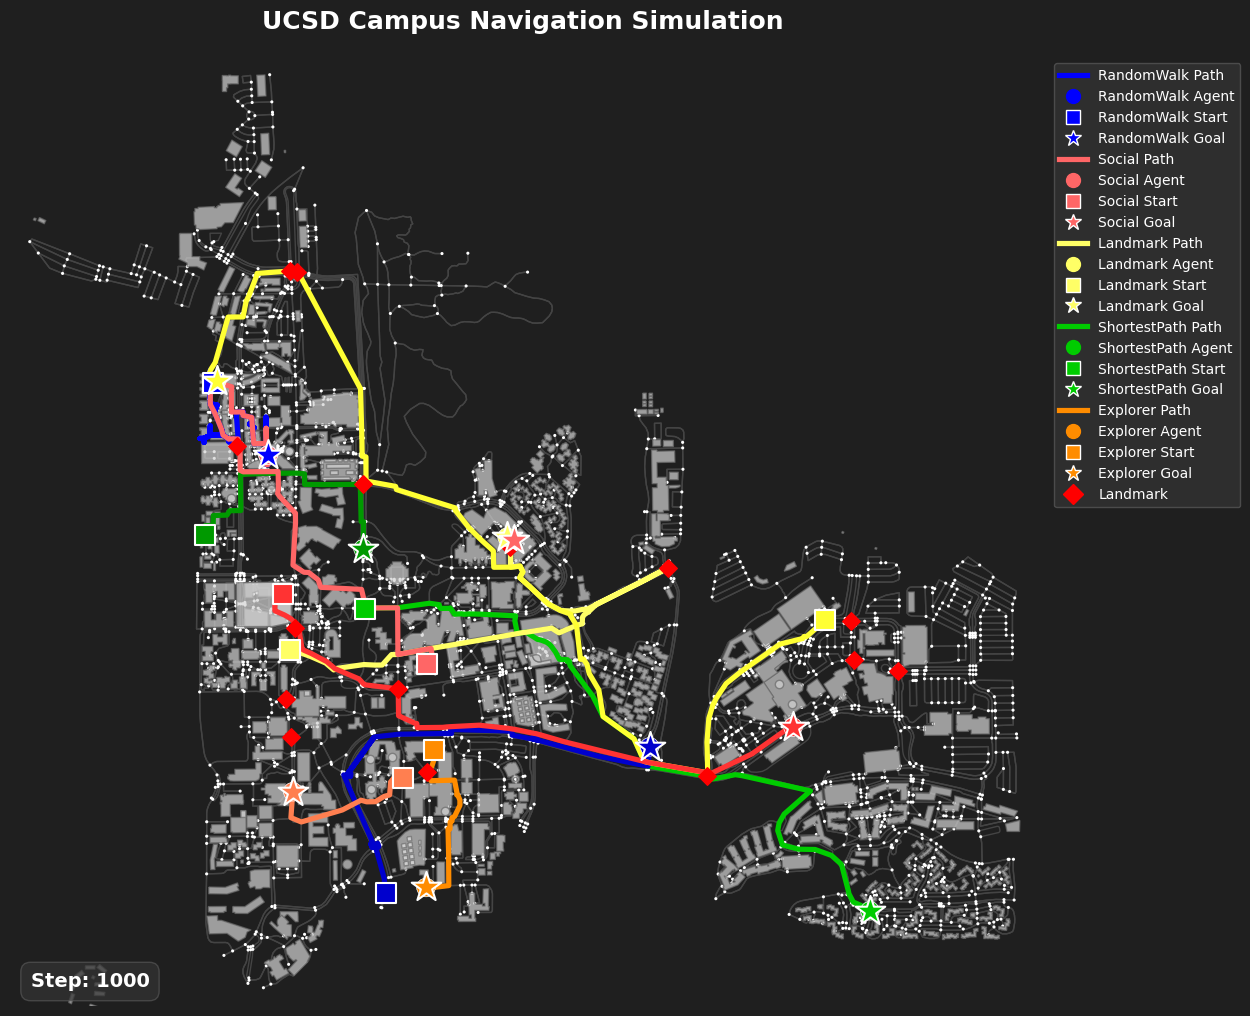

In [91]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

# Specify agent populations
agent_populations = {
    "shortest": 2,  # 2 shortest path agents
    "random": 2,    # 2 random walk agents
    "landmark": 2,  # 2 landmark-based agents
    "social": 2,    # 2 social agents
    "explorer": 2,  # 2 explorer agents
    #"obstacle": 2,  # 2 obstacle-avoiding agents
    #"scared": 2,    # 2 scared agents
    #"risky": 2      # 2 risky agents
}

# Create agents
agents = AgentFactory.populate_environment(campus, agent_populations)

# Create simulator and run
simulator = Simulator(campus, run_manager=run_manager)
simulator.run_simulation(
    max_steps=1000,
    animate=True,
    save_animation=True
)

In [92]:
# Get graph nodes and edges
nodes = campus.G.nodes()
edges = campus.G.edges()

# Access landmark and building data
landmarks = campus.landmarks
buildings = campus.buildings

In [107]:
agents[3].id

'RandomWalk_2'

### Building the MDP

In [94]:
goal_nodes = []
start_nodes = []
for agent in agents:
    goal_nodes.append(agent.goal_node)
    start_nodes.append(agent.start_node)

In [95]:
all_shortest_paths = dict(nx.all_pairs_shortest_path_length(campus.G))

In [96]:
# Compute Q-values
def Q_value(s, a, g):
    # Deterministic transition, next state = a
    return -all_shortest_paths[a][g]

In [97]:
# Posterior inference
def compute_goal_posterior(observed_trajectory, candidate_goals, beta=1.0):
    # observed_trajectory = [(s1,a1),(s2,a2),...(sT,aT)]
    posterior = {}
    prior = 1 / len(candidate_goals)  # uniform prior
    
    for g in candidate_goals:
        prob = prior
        for (s,a) in observed_trajectory:
            actions_possible = list(campus.G.neighbors(s))
            q_vals = np.array([Q_value(s, a_prime, g) for a_prime in actions_possible])
            likelihoods = np.exp(beta * q_vals)
            likelihoods /= likelihoods.sum()
            action_prob = likelihoods[actions_possible.index(a)]
            prob *= action_prob
        posterior[g] = prob
    
    # Normalize posterior
    total = sum(posterior.values())
    for g in posterior:
        posterior[g] /= total
    
    return posterior

In [102]:
path = agents[1].path
observed_trajectory = [(path[i], path[i+1]) for i in range(len(path)-10)]
goal_posterior = compute_goal_posterior(observed_trajectory, goal_nodes)

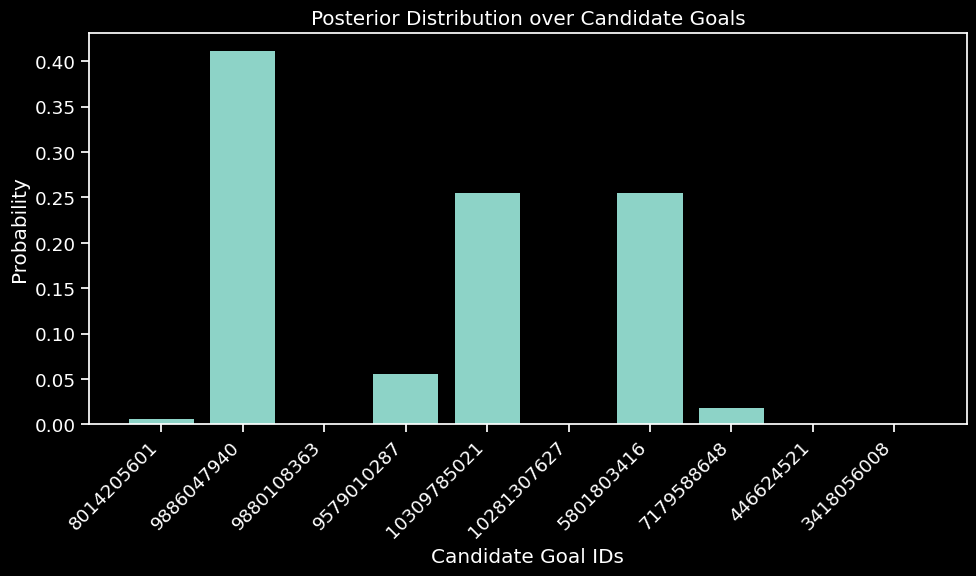

In [103]:
plot_goal_distribution(goal_posterior)

### Defning a BToM Class. 
Each agent will have it's own posterior. Thus, we should have a class that can define and keep track of this posterior for each agent. In this class we should take in an agent, set the agent id for the BToM, define the prior over the candidate goals, define an update posterior function which takes in a path and updates the posterior for each step in the path, and a return posterior function which provides the posterior over goals.  

Additionally, we should define a models utility folder for the random methods that are shared across BToM models, specifically, the Q_values that is derived from shortest paths. Or perhaps this should be defined in the simulation. 

In [136]:
class BToM:
    def __init__(self, campus, agents, beta=1.0):
        """
        Initializes the BToM model.
        
        Parameters:
        -----------
        campus : object
            An object that contains a NetworkX graph (campus.G).
        agents : list
            A list of agent objects. Each agent must have attributes:
              - id: a unique identifier,
              - goal_node: the agent's candidate goal node,
              - path: a list of nodes representing the agent's trajectory.
        beta : float, optional
            The inverse temperature parameter for the softmax.
        """
        self.campus = campus
        self.beta = beta
        
        print("Computing shortest paths...")
        # Compute shortest paths from all nodes to all nodes
        self.all_shortest_paths = dict(nx.all_pairs_shortest_path_length(campus.G))
        print("Done")
        
        # Set up candidate goals from agents (assume no duplicates)
        self.candidate_goals = [agent.goal_node for agent in agents]
        prior_prob = 1 / len(self.candidate_goals)
        # Create a uniform prior for candidate goals
        uniform_prior = {g: prior_prob for g in self.candidate_goals}
        
        # Initialize agent posteriors (each agent gets its own copy of the uniform prior)
        self.agent_posteriors = {agent.id: uniform_prior.copy() for agent in agents}
    
    def Q_value(self, s, a, g):
        """
        Computes the Q-value for transitioning from state s to next state a,
        given candidate goal g.
        
        Since transitions are deterministic in our graph, the Q-value is 
        defined as the negative shortest path length from a to g.
        """
        return -self.all_shortest_paths[a][g]
    
    def update_agent_posterior(self, agent, path_proportion=0.5):
        """
        Updates the posterior over candidate goals for a given agent using its trajectory.
        
        Parameters:
        -----------
        agent : object
            An agent with attributes 'id' and 'path' (a list of node IDs).
        path_proportion : float, optional
            Fraction of the trajectory to use in inference.
        
        Returns:
        --------
        posterior : dict
            The updated posterior distribution over candidate goals.
        """
        print(f"Updating posterior for agent {agent.id}")
        path = agent.path
        n_pairs = int(len(path) * path_proportion)
        # Convert the agent's path into state-action pairs:
        observed_trajectory = [(path[i], path[i+1]) for i in range(n_pairs)]
        
        # Retrieve the current posterior (initialized uniformly)
        posterior = self.agent_posteriors[agent.id].copy()
        for g in self.candidate_goals:
            prob = posterior[g]
            for (s, a) in observed_trajectory:
                # Determine possible actions (neighbors) from state s.
                actions_possible = list(self.campus.G.neighbors(s))
                if a not in actions_possible:
                    action_prob = 0.0
                else:
                    # Compute Q-values for all possible actions given goal g.
                    q_vals = np.array([self.Q_value(s, a_prime, g) for a_prime in actions_possible])
                    # Compute likelihoods using a Boltzmann (softmax) model.
                    likelihoods = np.exp(self.beta * q_vals)
                    likelihoods /= likelihoods.sum()
                    action_prob = likelihoods[actions_possible.index(a)]
                prob *= action_prob
            posterior[g] = prob
        
        # Normalize the posterior.
        total = sum(posterior.values())
        if total > 0:
            for g in posterior:
                posterior[g] /= total
        else:
            # If total probability is zero, reset to uniform.
            posterior = {g: 1 / len(self.candidate_goals) for g in self.candidate_goals}
        
        self.agent_posteriors[agent.id] = posterior
        return posterior

    def infer_goal(self, agent):
        """
        Infers the most likely goal for an agent by updating its posterior
        (if necessary) and selecting the goal with the highest probability.
        
        Parameters:
        -----------
        agent : object
            An agent with attributes 'id' and 'path'.
        
        Returns:
        --------
        inferred_goal : The candidate goal with the highest posterior probability.
        """
        posterior = self.update_agent_posterior(agent)
        inferred_goal = max(posterior, key=posterior.get)
        return inferred_goal

In [137]:
btom = BToM(campus, agents)

Computing shortest paths...
Done


In [138]:
agents[0]

In [139]:
posterior = btom.update_agent_posterior(agents[0])
posterior

Updating posterior for agent ShortestPath_1


{8014205601: np.float64(0.17871374114938554),
 9886047940: np.float64(1.336350665230182e-14),
 9880108363: np.float64(4.2899581791120287e-11),
 9579010287: np.float64(0.4106429557179688),
 10309785021: np.float64(1.133664654090005e-07),
 10281307627: np.float64(1.448809597493824e-12),
 5801803416: np.float64(2.684529225719682e-08),
 7179588648: np.float64(0.4106429557179689),
 446624521: np.float64(1.3904733200273184e-07),
 3418056008: np.float64(6.81112252629934e-08)}

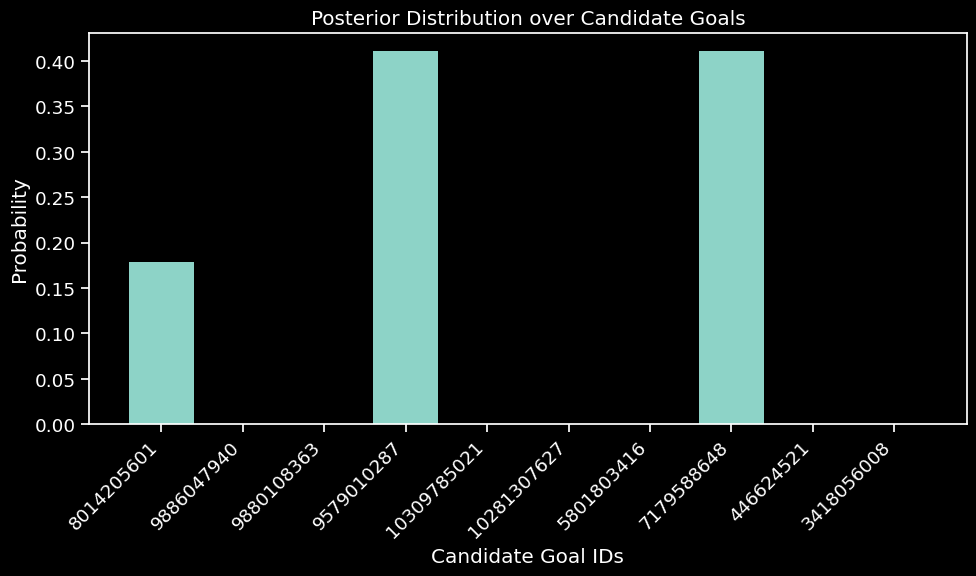

In [140]:
plot_goal_distribution(posterior)